The [VLAD](https://lear.inrialpes.fr/pubs/2010/JDSP10/jegou_compactimagerepresentation.pdf) (vector of locally aggregated descriptors) (no relation!) algorithm was proposed as a mechanism for compacting image descriptors ([related follow-on work](https://hal.inria.fr/hal-00840653v1/document)). This is useful for creating similarity search indices.

A reader of my blog referred me to this algorithm, noting that the supposedly vectorized version turns out slower than non-vectorized code. We review indexing and broadcasting rules to diagnose the slowdown and prescribe a fix with a lesser-known numpy gem for what's known as a scatter-reduce operation. If you've ever found yourself in a numpy setting wanting to "collect" the sum of some data into buckets determined at runtime, this gem is for you.

Along the way, we'll learn some pretty surprising facts about vectorization! What I thought was an idiomatic numpy solution using [`ufunc.at`](https://numpy.org/doc/stable/reference/generated/numpy.ufunc.at.html) turns out to be pretty non-performant!

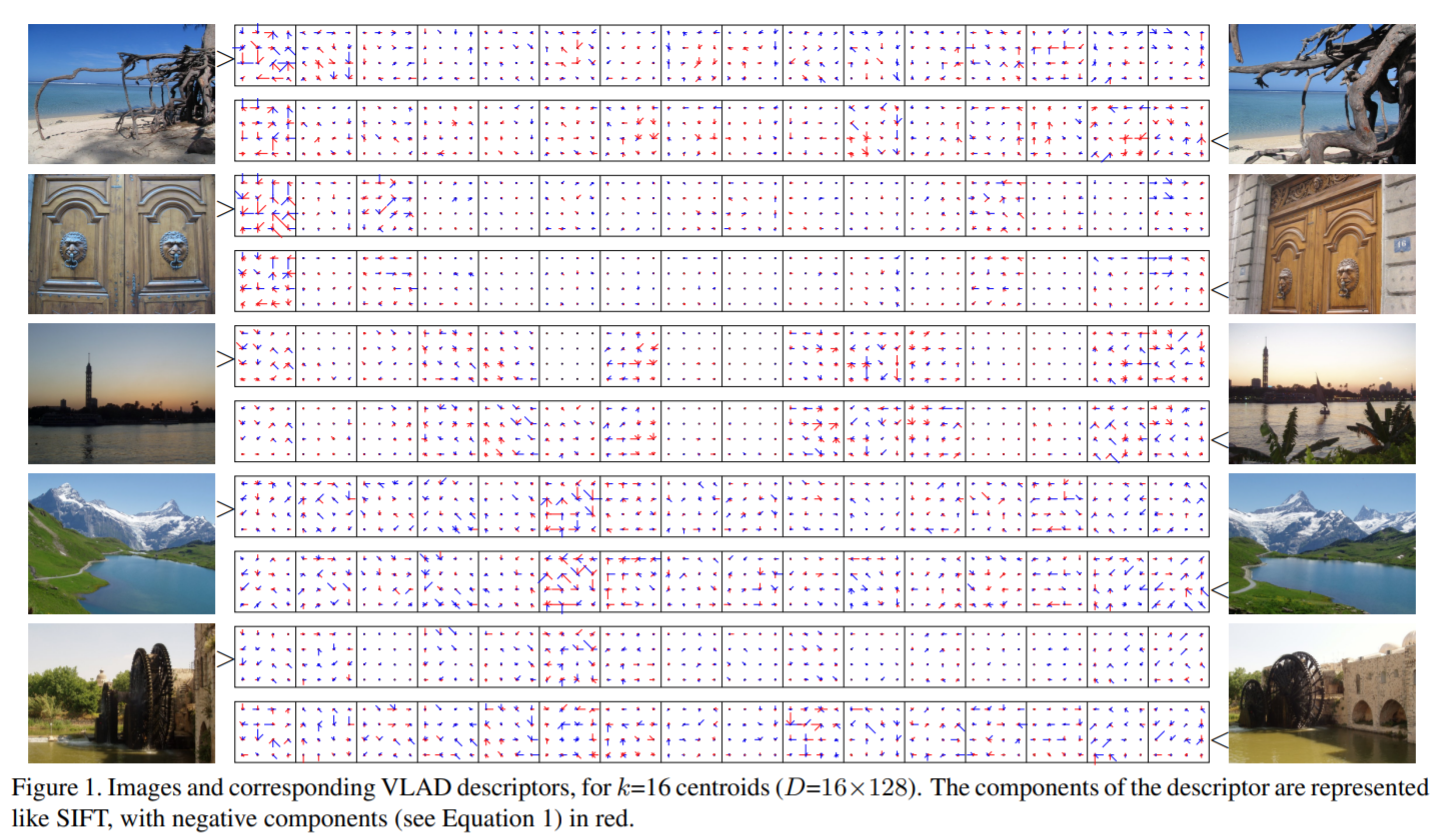

In [1]:
from IPython.display import Image
Image(filename='2021-09-15-vlad.png') 

For each of our $T$ images, we have $L$ "local descriptions", i.e., some $F$-dimensional feature vectors that semantically characterize certain attributes of each image. In other words, every image $t\in[T]$ has $L$ vectors $\textbf{v}_\ell^{(t)}\in\mathbb{R}^F$. Since $L$ may be large, and we'd like to compact the $L\times F$ data that we have per image, across all $L\times T$ feature vectors, we may consider some $K$ centroids $\textbf{c}_k$ from a $K$-means computation (again, looking indiscriminantly across all local descriptions).

Then VLAD defines, for each image $t$, a set of residual vectors which is the _sum of the errors_ that you get by approximating each local description to its closest centroid, i.e., for $k\in[K]$, $\textbf{r}_{k}^{(t)}=\sum_{\ell\in M_k^{(t)}}\textbf{v}_{\ell}^{(t)}-\textbf{c}_k$, where $M_k^{(t)}=\{\ell\in[L]\,\big|\,k=\mathrm{argmin}_{k'}\|\textbf{c}_{k'}-\textbf{v}_\ell^{(t)}\|_2\}$.

Finally, the actual VLAD encoding for the $t$-th image is the $D$-sized vector $n(\textbf{u})$, where $\textbf{u}=\mathrm{stack}\left(\{\textbf{r}_k^{(t)}\}_{k\in[K]}\right)$, $D=K\times F$, and $n$ is some normalization (varies between implementations). Speaking very intuitively, we can imagine the components of VLAD to being something like the score statistic for a GMM model, assuming the latent assignment (from local aggregate to the cluster it belongs to) is known.

VLAD is quite compute-intensive, and due to its hyperparemeters (such as $F$ and $K$) requiring tuning, optimization of its transformation can be a big quality-of-life improvement!

A direct implementation is below, along with an initial vectorization attempt I found on Stack Overflow (but re-written to make broadcasting clear). Note that for simplicity we have $L$ be a constant, but the approach described in this blog post can be extended to allow for an image-dependent number of local descriptors $L^{(t)}$.

In [2]:
import numpy as np
from sklearn.cluster import MiniBatchKMeans

def looping(kmeans: MiniBatchKMeans, local_tlf):
    k, (t, l, f) = kmeans.n_clusters, local_tlf.shape
    centers_kf = kmeans.cluster_centers_
    vlad_tkf = np.zeros((t, k, f))
    for vlad_kf, local_lf in zip(vlad_tkf, local_tlf):
        label_l = kmeans.predict(local_lf)
        for i in range(k):
            vlad_kf[i] = np.sum(local_lf[label_l == i] - centers_kf[i], axis=0)
        vlad_D = vlad_kf.ravel()
        vlad_D = np.sign(vlad_D) * np.sqrt(np.abs(vlad_D))
        vlad_D /= np.linalg.norm(vlad_D)
        vlad_kf[:,:] = vlad_D.reshape(k, f)
    return vlad_tkf.reshape(t, -1)

def naivec(kmeans: MiniBatchKMeans, local_tlf):
    k, (t, l, f) = kmeans.n_clusters, local_tlf.shape
    centers_kf = kmeans.cluster_centers_
    labels_tl = kmeans.predict(local_tlf.reshape(-1,f)).reshape(t, l)
    mask_tlk = labels_tl[..., np.newaxis] == np.arange(k)
    local_tl1f = local_tlf[...,np.newaxis,:]
    delta_tlkf = local_tl1f - centers_kf # <-- easy to run out of memory
    vlad_tD = (delta_tlkf * mask_tlk[..., np.newaxis]).sum(axis=1).reshape(t, -1)
    vlad_tD = np.sign(vlad_tD) * np.sqrt(np.abs(vlad_tD))
    vlad_tD /= np.linalg.norm(vlad_tD, axis=1, keepdims=True)
    return vlad_tD

On a simple benchmark, we notice the vectorization performs poorly. The reason boils down to doing a lot more work than necessary on the `delta_tlkf = local_tl1f - centers_kf` and `(delta_tlkf * mask_tlk[..., np.newaxis]).sum(axis=1)` steps. We're using a dense 4D tensor but only ever looking at 3 dimensions of it!

In [3]:
np.random.seed(1234)
# usually there are a lot more images than this
t, l, f, k = 256, 128, 64, 512
X = np.random.randn(t, l, f)
km = MiniBatchKMeans(n_clusters=16, n_init=10, random_state=0)
km.fit(X.reshape(-1, f))

result_looping = looping(km, X)
result_naivec = naivec(km, X)

%timeit looping(km, X)
%timeit naivec(km, X)

assert np.allclose(result_looping, result_naivec)

197 ms ± 13.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
313 ms ± 33.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


While masks like this are often an easy way of vectorizing, they can result in wasted work. This brings us to our numpy gem: if you find yourself using a mask which is only nonzero in exactly one (or a few) locations for a dimension, then you can replace it with one (or a few) calls to [`ufunc.at`](https://numpy.org/doc/stable/reference/generated/numpy.ufunc.at.html).

The core of the VLAD computation that's difficult to vectorize is the residual sum: $\textbf{r}_{k}^{(t)}=\sum_{\ell\in M_k}\textbf{v}_{\ell}^{(t)}-\textbf{c}_k$. But we could represent $M_k^{(t)}$ across all $k,t$ with a label array and in a sense such a label array would tell us "where" to add the corresponding $\textbf{v}_{\ell}^{(t)}$. In scientific computing this is called a [scatter](https://en.wikipedia.org/wiki/Gather-scatter_(vector_addressing)) operation.

In numpy, you may have attempted to use in-place advanced indexing addition or reduction but found that, due to buffering, duplicate values are not collected together. For instance:

In [4]:
x = np.zeros(5)
x[[1, 1, 2, 2]] += np.ones(4)
x # want [0, 2, 2, 0, 0] but instead get...

array([0., 1., 1., 0., 0.])

The above behavior isn't obvious from the [advanced indexing](https://numpy.org/doc/stable/reference/arrays.indexing.html) docs, since it requires an understanding of how python [de-sugars](https://stackoverflow.com/questions/58657486/how-to-execute-an-advanced-indexed-in-place-augmented-assign-to-a-numpy-vect) the in-place addition. As mentioned before, `ufunc.at` saves the day.

In [5]:
x = np.zeros(5)
np.add.at(x, [1, 1, 2, 2], np.ones(4))
x

array([0., 2., 2., 0., 0.])

We can now re-visit VLAD vectorization.

In [6]:
def truvec(kmeans: MiniBatchKMeans, local_tlf):
    k, (t, l, f) = kmeans.n_clusters, local_tlf.shape
    centers_kf = kmeans.cluster_centers_
    labels_tl = kmeans.predict(local_tlf.reshape(-1,f)).reshape(t, l)
    
    vlad_tkf = np.zeros((t, k, f))
    M = t * k
    labels_tl += np.arange(t)[:, np.newaxis] * k
    vlad_Mf = vlad_tkf.reshape(-1, f)
    np.add.at(vlad_Mf, labels_tl.ravel(), local_tlf.reshape(-1, f))
    counts_M = np.bincount(labels_tl.ravel(), minlength=M)
    vlad_tkf -= counts_M.reshape(t, k, 1) * centers_kf
    
    vlad_tD = vlad_tkf.reshape(t, -1)
    vlad_tD = np.sign(vlad_tD) * np.sqrt(np.abs(vlad_tD))
    vlad_tD /= np.linalg.norm(vlad_tD, axis=1, keepdims=True)
    return vlad_tD

result_truvec = truvec(km, X)
assert np.allclose(result_looping, result_truvec)
%timeit truvec(km, X)

208 ms ± 3.78 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Wow! I admit I was pretty surprised by this initially. While this is certainly an improvement over `naivec`, why is a python loop performing about as good as a supposedly-vectorized approach?

It turns out the so-called "supposedly-vectorized approach" is actually _hurting_ vectorization. The code `np.sum(local_lf[labels_l == i], axis=0)` can leverage actual strided vectorized addition instructions, since it's summing a contiguous array (generated on-the-fly) whereas `np.add.at` is forced to use non-vectorized adds as it's adding in arbitrarily-located slices.

So can we do better with an approach that avoids python for-loops? Indeed, but we'll need to re-use a previous numpy gem. **In effect, we should perform scatter reduction by re-interpreting the array as a ragged array.** In doing so, and applying the techniques from the [Vectorizing Ragged Arrays](https://vladfeinberg.com/2021/01/07/vectorizing-ragged-arrays.html) blog post, we can perform contiguous reductions which the looping approach requires to be strided!

In [7]:
def optvec(kmeans: MiniBatchKMeans, local_tlf):
    k, (t, l, f) = kmeans.n_clusters, local_tlf.shape
    centers_kf = kmeans.cluster_centers_
    label_tl = kmeans.predict(local_tlf.reshape(-1,f)).reshape(t, l)
    
    vlad_tkf = np.zeros((t, k, f))
    M = t * k
    label_tl += np.arange(t)[:, np.newaxis] * k
    N = t * l
    label_N = label_tl.reshape(N)
    local_fN = local_tlf.reshape(N, f).T
    ix_N = np.argsort(label_N)
    local_fN = local_fN[:, ix_N]
    label_N = label_N[ix_N]
        
    # ragged array vectorization, see linked post
    label_switch_N = np.diff(label_N, prepend=0)
    pos = np.flatnonzero(label_switch_N)
    pos = np.repeat(pos, label_switch_N[pos])
    pos = np.append(pos, N)
    pos -= 1
    assert len(pos) == M, (len(pos), M)
    pos_M = pos
    
    np.cumsum(local_fN, axis=1, out=local_fN)
    clustered_fM = np.diff(local_fN[:, pos_M], axis=1, prepend=np.zeros_like(local_fN[:,0:1]))
    vlad_tkf = clustered_fM.T.reshape(t, k, f)
    
    counts_M = np.diff(pos_M, prepend=-1)
    vlad_tkf -= counts_M.reshape(t, k, 1) * centers_kf
    
    vlad_tD = vlad_tkf.reshape(t, -1)
    vlad_tD = np.sign(vlad_tD) * np.sqrt(np.abs(vlad_tD))
    vlad_tD /= np.linalg.norm(vlad_tD, axis=1, keepdims=True)
    return vlad_tD

result_optvec = optvec(km, X)
assert np.allclose(result_looping, result_optvec), sum(result_looping != result_optvec)

%timeit optvec(km, X)

127 ms ± 11.3 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


OK, so with all this work, we've gotten a modest improvement of around 40%, but I'm sure in some settings, such as when $F$ is large or $L\gg K$, the original python loop approach works fine. This is because there's enough work being done in the inner loop of the `looping()` function that additional vectorization is not that necessary.

However, one benefit to the final implementation is it could, with a little bit of effort, be translated to `jax`. This would let us run the same computation entirely on a hardware accelerator. Experimenting with this ([Collab link](https://colab.research.google.com/drive/1kz3MZKhVt3zcsz9tD4F49-3nnZi0xjiy?usp=sharing)), I was able to get a `4x` improvement over the original looping code by leveraging a TPU. Now that's more like it!

I'd like to extend a special thank you to [Ashwin Nair](https://stackoverflow.com/questions/69085744/vectorise-vlad-computation-in-numpy) for emailing me this interesting challenge. I always find these numpy questions fun and encourage my other readers to reach out! If they require a new technique I haven't covered in my previous "Numpy Gems" posts, I'd be happy to take a look.